In [2]:
pip install textblob


  Using cached textblob-0.18.0.post0-py3-none-any.whl.metadata (4.5 kB)
Using cached textblob-0.18.0.post0-py3-none-any.whl (626 kB)
Note: you may need to restart the kernel to use updated packages.


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import ExtraTreesRegressor
from textblob import TextBlob
import chardet

In [4]:
with open('Rotten_Tomatoes_Movies3.csv', 'rb') as file:
    result = chardet.detect(file.read())
    encoding = result['encoding']

df = pd.read_csv('Rotten_Tomatoes_Movies3.csv', encoding=encoding)

In [5]:
print("First 5 rows of the dataset:")
print(df.head())

First 5 rows of the dataset:
                                         movie_title  \
0  Percy Jackson & the Olympians: The Lightning T...   
1                                        Please Give   
2                                                 10   
3                    12 Angry Men (Twelve Angry Men)   
4                       20,000 Leagues Under The Sea   

                                          movie_info  \
0  A teenager discovers he's the descendant of a ...   
1  Kate has a lot on her mind. There's the ethics...   
2  Blake Edwards' 10 stars Dudley Moore as George...   
3  A Puerto Rican youth is on trial for murder, a...   
4  This 1954 Disney version of Jules Verne's 20,0...   

                                   critics_consensus rating  \
0  Though it may seem like just another Harry Pot...     PG   
1  Nicole Holofcener's newest might seem slight i...      R   
2                                                NaN      R   
3  Sidney Lumet's feature debut is a superbly

In [6]:
print("\nDataset Information:")
print(df.info())



Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16638 entries, 0 to 16637
Data columns (total 16 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   movie_title         16638 non-null  object 
 1   movie_info          16614 non-null  object 
 2   critics_consensus   8309 non-null   object 
 3   rating              16638 non-null  object 
 4   genre               16621 non-null  object 
 5   directors           16524 non-null  object 
 6   writers             15289 non-null  object 
 7   cast                16354 non-null  object 
 8   in_theaters_date    15823 non-null  object 
 9   on_streaming_date   16636 non-null  object 
 10  runtime_in_minutes  16483 non-null  float64
 11  studio_name         16222 non-null  object 
 12  tomatometer_status  16638 non-null  object 
 13  tomatometer_rating  16638 non-null  int64  
 14  tomatometer_count   16638 non-null  int64  
 15  audience_rating     16386 non-n

In [7]:
print("\nMissing Values:")
print(df.isnull().sum())


Missing Values:
movie_title              0
movie_info              24
critics_consensus     8329
rating                   0
genre                   17
directors              114
writers               1349
cast                   284
in_theaters_date       815
on_streaming_date        2
runtime_in_minutes     155
studio_name            416
tomatometer_status       0
tomatometer_rating       0
tomatometer_count        0
audience_rating        252
dtype: int64


C:\Users\charl\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


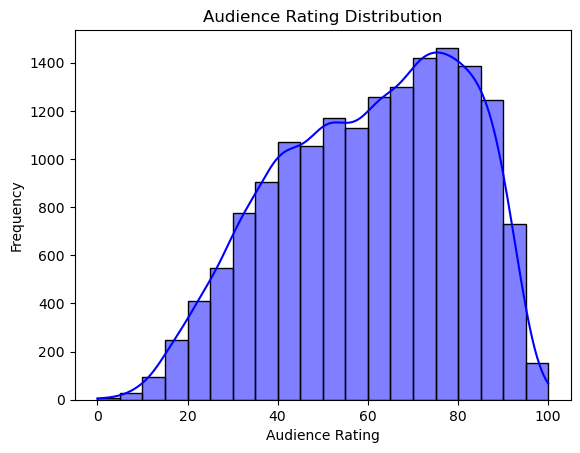

In [8]:
sns.histplot(df['audience_rating'], bins=20, kde=True, color='blue')
plt.title('Audience Rating Distribution')
plt.xlabel('Audience Rating')
plt.ylabel('Frequency')
plt.show()

In [9]:
def extract_sentiment(text):
    if pd.isna(text):
        return 0  # Neutral sentiment if text is missing
    return TextBlob(text).sentiment.polarity

df['critics_sentiment'] = df['critics_consensus'].apply(extract_sentiment)

# Parse and clean date columns
df['in_theaters_year'] = pd.to_datetime(df['in_theaters_date'], dayfirst=True, errors='coerce').dt.year
df['on_streaming_year'] = pd.to_datetime(df['on_streaming_date'], dayfirst=True, errors='coerce').dt.year
df.drop(['in_theaters_date', 'on_streaming_date'], axis=1, inplace=True)
df['in_theaters_year'].fillna(df['in_theaters_year'].mode()[0], inplace=True)
df['on_streaming_year'].fillna(df['on_streaming_year'].mode()[0], inplace=True)

#Handle missing audience ratings
df = df.dropna(subset=['audience_rating'])

In [10]:
categorical_cols = ['directors', 'writers', 'cast', 'studio_name', 'tomatometer_status', 'rating', 'genre']
numerical_cols = ['runtime_in_minutes', 'tomatometer_rating', 'tomatometer_count', 'in_theaters_year', 
                  'on_streaming_year', 'critics_sentiment']

available_categorical_cols = [col for col in categorical_cols if col in df.columns]
available_numerical_cols = [col for col in numerical_cols if col in df.columns]

X = df[available_categorical_cols + available_numerical_cols]
y = df['audience_rating']

#Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#Preprocessing
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, available_numerical_cols),
        ('cat', categorical_transformer, available_categorical_cols)
    ]
)

In [11]:
models = {
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, random_state=42),
    'Extra Trees': ExtraTreesRegressor(n_estimators=100, random_state=42)
}

results = {}

for model_name, model in models.items():
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('model', model)
    ])
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    results[model_name] = {'MAE': mae, 'RMSE': rmse, 'R-squared': r2}
    print(f"\n{model_name} Results:")
    print(f"MAE: {mae:.2f}, RMSE: {rmse:.2f}, R-squared: {r2:.2f}")


Linear Regression Results:
MAE: 11.84, RMSE: 15.29, R-squared: 0.43

Random Forest Results:
MAE: 10.77, RMSE: 14.01, R-squared: 0.52

Gradient Boosting Results:
MAE: 10.92, RMSE: 13.81, R-squared: 0.54

Extra Trees Results:
MAE: 10.76, RMSE: 14.14, R-squared: 0.52


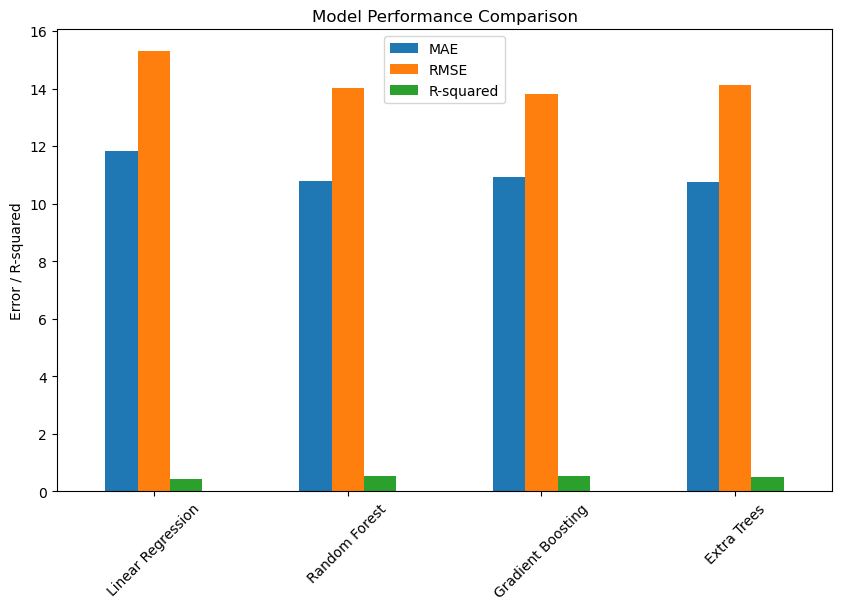

The best performing model is: Gradient Boosting


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['runtime_in_minutes',
                                                   'tomatometer_rating',
                                                   'tomatometer_count',
                                                   'in_theaters_year',
                                                   'on_streaming_year',
                                                   'critics_sentiment']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['directors', 'writers',
                                                   'cast', 'studio_name',
                                                   'tomatometer_status',
                                                   'rating', 'genre'])])),
                ('model', GradientBoostingRegressor(random_state=42))])

In [12]:
result_df = pd.DataFrame(results).T
result_df.plot(kind='bar', figsize=(10, 6))
plt.title('Model Performance Comparison')
plt.ylabel('Error / R-squared')
plt.xticks(rotation=45)
plt.show()

# Selecting (R-Square)
best_model_name = result_df['R-squared'].idxmax()
print(f"The best performing model is: {best_model_name}")

best_model = models[best_model_name]
final_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', best_model)
])
final_pipeline.fit(X_train, y_train)

In [ ]:
#Main Fucntion

def predict_audience_rating():
    print("\nEnter movie details for prediction:")
    runtime = float(input("Runtime in minutes: "))
    tomatometer_rating = float(input("Tomatometer rating (0-100): "))
    tomatometer_count = int(input("Tomatometer count: "))
    genre = input("Genre (e.g., Action & Adventure, Comedy, Drama): ")
    rating = input("Rating (PG, R, NR, PG-13, G): ")
    critics_consensus = input("Critics Consensus: ")

    input_data = pd.DataFrame({
        'runtime_in_minutes': [runtime],
        'tomatometer_rating': [tomatometer_rating],
        'tomatometer_count': [tomatometer_count],
        'genre': [genre],
        'rating': [rating],
        'critics_sentiment': [extract_sentiment(critics_consensus)]
    })
    for col in available_categorical_cols + available_numerical_cols:
        if col not in input_data.columns:
            input_data[col] = np.nan  # Add missing columns as NaN

    prediction = final_pipeline.predict(input_data)
    print(f"\nPredicted Audience Rating: {prediction[0]:.2f}")

predict_audience_rating()


Enter movie details for prediction:
